In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Extracting two paths, one of which may be attacked

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


df1 = pd.read_csv('/content/drive/MyDrive/Rick- Anomaly Detection/Data/Yang/Matrix_sensor_path5_v1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Rick- Anomaly Detection/Data/Yang/Matrix_sensor_path5_v2.csv')
df1 = df1.drop(columns=['Unnamed: 0'])
df2 = df2.drop(columns=['Unnamed: 0'])

In [10]:
# df2 = pd.DataFrame(df2, columns = df1.columns)

df2.head()

,protected_sensor2,sensor2_1,sensor2_2,sensor2_3,sensor2_4,sensor2_5
0,9.989763,10.003115,10.003452,10.007273,9.988044,9.998783
1,10.006256,9.996641,9.993156,10.014655,9.994584,9.996212
2,9.998943,10.007696,10.020955,9.985223,10.006493,9.979732
3,10.016738,10.001262,9.985183,9.996511,9.990933,10.009697
4,10.003835,10.011487,9.993151,10.003441,10.004385,10.010990


<function matplotlib.pyplot.show(close=None, block=None)>

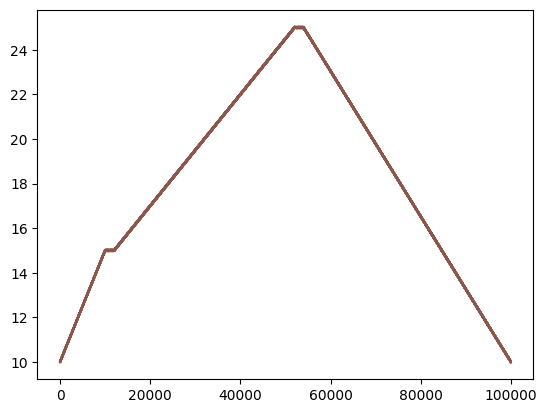

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



plt.plot(range(len(df1['protected_sensor'])), df1['protected_sensor'])
plt.plot(range(len(df1['sensor1'])), df1['sensor1'])
plt.plot(range(len(df1['sensor2'])), df1['sensor2'])
plt.plot(range(len(df1['sensor3'])), df1['sensor3'])
plt.plot(range(len(df1['sensor4'])), df1['sensor4'])
plt.plot(range(len(df1['sensor5'])), df1['sensor5'])

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

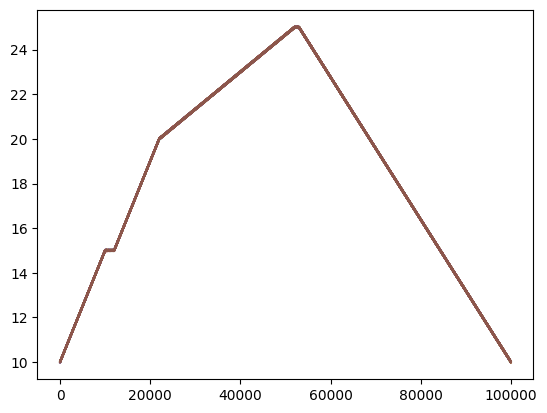

In [11]:

plt.plot(range(len(df2['protected_sensor2'])), df2['protected_sensor2'])
plt.plot(range(len(df2['sensor2_1'])), df2['sensor2_1'])
plt.plot(range(len(df2['sensor2_2'])), df2['sensor2_2'])
plt.plot(range(len(df2['sensor2_3'])), df2['sensor2_3'])
plt.plot(range(len(df2['sensor2_4'])), df2['sensor2_4'])
plt.plot(range(len(df2['sensor2_5'])), df2['sensor2_5'])
plt.show

In [5]:
# df['@id'] = df['@id'].astype(np.float64)

# df_for22 = df[df['@id'] == 22]
# df_for60 = df[df['@id'] == 60]
# # df_for1 = df_for1.append(df_for60)
# df_for22

In [12]:
import numpy as np
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
# from tadgan_tf2 import preprocessing


import tensorflow as tf
import time

from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense, Conv1D, UpSampling1D, Cropping1D, \
    LSTM, Bidirectional, TimeDistributed, LeakyReLU, Dropout, Flatten, Reshape

In [13]:
# Functions for preprocessing of data


def rolling_windows(x, t, window_size, step_size=1):
    """Split time series data into rolling windows.
    
    The time series data (x) are expected to be an nD array, with n >= 1 and
    of the shape (# time stamps, ...); and the time stamps (t) in the form of
    a 1D-array are expected to be provided separately.
    
    The outputs are the windowed data (x_win) in the form of an (n+1)D array
    of the shape (# windows, window size, ...); and start times of the windows
    (t_win).
    """
    assert len(x) == len(t)
    n_windows = (len(x) - window_size) // step_size + 1
    x_win = np.full((n_windows, window_size, *(x.shape[1:])), np.nan)
    for i in range(window_size):
        x_win[:, i] = x[i::step_size][:n_windows]
    t_win = t[::step_size][:n_windows]
    return x_win, t_win
        

def pre_proc_apply_pipeline(x, freq, window_size):

    '''Apply a pipeline of preprocessing steps to transform raw time series 
    data into the required format for the reconstruction model (TadGAN).
    
    Parameters
    ----------
    x : pandas series indexed by datetimes
        Time series data.
    
    freq : str
        Resampling frequency, of the same format as the first argument of
        pandas.Series.resample().
    
    window_size : int
        Size of rolling windows of the preprocessed time series.
    
    Returns
    -------
    x : 1D-array
        Preprocessed time series.
                                                    
    t : 1D-array
        Time stamps of x.
    
    x_win : 2D-array
        Rolling windows of the preprocessed time series, of the shape
        (# windows, window size).
    
    t_win : 1D-array
        Starting time stamps of the rolling windows.
    '''

    x = x.resample(freq).sum()
    x, t = x.to_numpy(), x.index.to_numpy()
    x = x.reshape(-1, 1)
    x = SimpleImputer().fit_transform(x)
    x = MinMaxScaler(feature_range=(-1, 1)).fit_transform(x)
    x = x.reshape(-1)
    x_win, t_win = rolling_windows(x, t, window_size)
    
    return x, t, x_win, t_win


In [14]:
# Post processing for data

def merge_rolling_windows(x_win, step_size=1):
    '''Merge rolling-window time series data into single time series by taking
    median values per time stamp.
    
    The rolling window data (x_win) is expected to be an nD array, with n >= 2
    and of the shape (# windows, window size, ...).
    
    The output is the combined time series (x) in the form of an (n-1)D array
    of the shape (# time stamps, ...).
    '''
    n_windows, window_size = x_win.shape[:2]
    n = (n_windows - 1) * step_size + window_size
    x_mult = np.full((n, window_size, *(x_win.shape[2:])), np.nan)
    for i in range(window_size):
        x_mult[i::step_size, i][:n_windows] = x_win[:, i]
    x = np.nanmedian(x_mult, axis=1)
    return x


def _window_with_pad(a, window, pad_value, win_first=False):
    '''Helper function. Split a sequence into rolling windows after some
    padding, so that the number of windows equals the length of the sequence.
    '''
    pad_sizes = [(0, 0)] * len(a.shape)
    pad_sizes[0] = (window // 2, window - window // 2 - 1)
    a = np.pad(a, pad_sizes, 'constant', constant_values=pad_value)
    dummy_id = np.zeros(a.shape[0])
    a, _ = rolling_windows(a, dummy_id, window)
    if win_first:
        a = np.transpose(a, (1, 0, *range(2, len(a.shape))))
    return a


def _batch_dtw(a1, a2):
    '''Calculate the dynamic time warping distances between pairs of time 
    series in batch.
    
    The batches of time series (a1, a2) are expected to be nD arrays, with
    their first dimensions representing time and other dimensions identical.
    
    The output is the resulting batch of distances, as an (n-1)D array.
    '''
    assert a1.shape[1:] == a2.shape[1:]
    dtw = np.full((a1.shape[0]+1, a2.shape[0]+1, *(a1.shape[1:])), np.inf)
    dtw[0, 0] = 0
    for i in range(a1.shape[0]):
        for j in range(a2.shape[0]):
            dtw[i+1, j+1] = np.absolute(a1[i] - a2[j]) \
                + np.minimum(np.minimum(dtw[i, j+1], dtw[i+1, j]), dtw[i, j])
    return dtw[-1, -1]


def reconstruction_error_scores(x, x_recon, dtw_window=10, smooth_window=None, normalize=True):
    
    '''Evaluate the reconstruction of time series based on the rolling DTW
    (dynamic time warping) differences between the original and reconstructed 
    series.
    
    Parameters
    ----------
    x, x_recon : nD arrays
        Original and reconstructed time series data. The arrays are expected to
        have the same shape, with the first dimension representing time.
    
    dtw_window : int
        Size of the rolling windows for calculation of DTW distances.
    smooth_window : int or None
        Size of the rolling windows for calculation of running averages. If
        None, no such smoothing is applied.
    
    normalize : bool
        Whether to normalize the scores. 
    Returns
    -------
    scores : nD array
        Scores of reconstruction errors. The array has the same shape as the
        given time series data.
    '''
    
    assert x.shape == x_recon.shape

    # calculate rolling DTW distances between original and reconstructed series
    x_win = _window_with_pad(x, dtw_window, 0, win_first=True)
    x_recon_win = _window_with_pad(x_recon, dtw_window, 0, win_first=True)
    scores = _batch_dtw(x_win, x_recon_win)
    del x_win, x_recon_win
    
    # smooth score series by taking rolling averages
    if smooth_window:
        scores = np.nanmean(_window_with_pad(scores, smooth_window, np.nan), axis=1)
    
    # normalize scores (and take positive part only)
    if normalize:
        mean, sd = np.mean(scores, axis=0), np.std(scores, axis=0)
        scores = np.maximum(scores - mean, 0) / (sd + 1e-8)

    return scores


def _kde_mode(a):
    '''Find the element of a sequence with the highest Gaussian KDE.'''
    a = a[~np.isnan(a)]
    if len(a) == 1 or a.std() == 0.0:
        return a.mean()
    kde = stats.gaussian_kde(a)(a)
    mode = a[np.argmax(kde)]
    return mode


def unroll_critic_scores(scores_win, window_size, step_size=1, smooth_window=None, normalize=True):

    '''Transform critic scores associated to rolling windows (as produced by
    the reconstruction model) into values associated to individual time stamps.
    
    Parameters
    ----------
    scores_win : nD array
        Critic scores associated to rolling windows, of the shape (# windows,
        ...).                                                                       
    
    window_size : int
        Size of the underlying rolling windows.
    
    step_size : int
        Number of time stamps between successive windows.
    
    smooth_window : int or None
        Size of the rolling windows for calculation of running averages. If
        None, no such smoothing is applied.
    
    normalize : bool
        Whether to normalize the scores. 
    
    Returns
    -------
    scores : nD array
        Transformed critic scores, of the shape (# time stamps, ...).
    '''
    
    # take the majority value (in the sense of maximal Gaussian KDE) among the
    # scores associated to the rolling windows covering each time stamp
    n_windows = scores_win.shape[0]
    n = (n_windows - 1) * step_size + window_size
    scores_mult = np.full((n, window_size, *scores_win.shape[1:]), np.nan)
    for i in range(window_size):
        scores_mult[i::step_size, i][:n_windows] = scores_win
    scores = np.apply_along_axis(_kde_mode, 1, scores_mult)
    del scores_mult
    
    # smooth score series by taking rolling averages
    if smooth_window:
        scores = np.nanmean(_window_with_pad(scores, smooth_window, np.nan), axis=1)

    # normalize scores and take absolute values
    # Note: Unlike the original version, the mean is taken over all values
    # instead of only the values in the middle two quartiles.
    if normalize:
        mean, sd = np.mean(scores, axis=0), np.std(scores, axis=0)
        scores = np.absolute(scores - mean) / (sd + 1e-8)
    
    return scores


def _consec_seqs(bools):
    '''Locate the consecutive sequences of True in a 1D array of Booleans.'''
    starts = np.argwhere(bools & np.insert(~bools[:-1], 0, True)).flatten()
    ends = np.argwhere(bools & np.append(~bools[1:], True)).flatten() + 1
    return np.stack([starts, ends], axis=1)


def _find_local_anomalies(scores, threshold, pad=None):
    '''Locate consecutive sequences of scores exceeding a threshold, with the
    option of including positions within a given distance (pad).
    
    The scores are expected to be a 1D array.
    
    The outputs consist of a pandas data frame containing the endpoints of, and
    maximum score within, each sequence; as well as the maximum score outside
    all sequences.
    '''
    # locate sequences of scores exceeding the threshold
    anomalous = (scores > threshold)
    seqs = _consec_seqs(anomalous)

    # include positions within a given distance
    if pad and (pad > 0):
        for start, end in seqs:
            anomalous[max(start - pad, 0) : start] = True
            anomalous[end : min(end + pad, len(scores))] = True
        seqs = _consec_seqs(anomalous)

    # attach max scores within each sequence / outside all
    seqs = pd.DataFrame(seqs, columns=['start', 'end'])
    seqs['max_score'] = seqs.apply(lambda x: scores[x['start'] : x['end']].max(), axis=1)
    max_score_rest = 0 if anomalous.all() else scores[~anomalous].max()

    return seqs, max_score_rest


def identify_anomalous_sequences(scores, t, sd_threshold=4.0, pad=None,
                                 local_window=None, local_window_step=None, prune_param=None):
    
    '''Identify anomalous sequences in a series of scores. A score is flagged
    as anomalous if it exceeds the mean score by a specified number of standard
    deviations; and this is carried out in the context of the entire series 
    (global anomalies) as well as specified segments of it (local anomalies). 
    Any overlapping sequences thus obtained are subsequently merged.
    Parameters
    ----------
    scores : 1D array
        Scores used to identify anomalous sequences.
    
    t : 1D array
        Underlying time stamps associated to the scores.
        
    sd_threshold : float
        Threshold for a score to be considered anomalous, as measured in number
        of standard deviations from the mean.
        
    pad : int or None
        Number of extra time stamps to be included at both ends of each
        anomalous sequence. If None, no extra time stamps are included.
    
    local_window : int or None
        Size of rolling windows used in the search of local anomalies. If None,
        it is set to be 33% of the length of the series.
    
    local_window_step : int or None
        Number of steps between successive rolling windows used in the search 
        of local anomalies. If None, it is set to be 10% of the length of the
        series.
        
    prune_param : float or None
        Parameter of a pruning procedure for the locally identified sequences.
        If None, no pruning is applied.
    
    Returns
    -------
    seqs : pandas DataFrame
        Identified anomalous sequences as indicated by the first and last time
        stamps (start, end), together with associated scores (score).
    '''
    
    n = len(scores)
    local_window = local_window or int(n * 0.33)
    local_window_step = local_window_step or int(n * 0.1)
    all_local_seqs = []
    
    for window, step in [(n, 1), (local_window, local_window_step)]:

        n_windows = (n - window - 1) // step + 2
        for i in range(n_windows):
            
            window_start = i * step
            local_scores = scores[window_start : window_start + window]
            mean, sd = local_scores.mean(), local_scores.std()
            
            # identify anomalies based on a threshold
            threshold = mean + sd * sd_threshold  
            if local_scores.max() <= threshold:
                continue
            local_seqs, max_score_rest = _find_local_anomalies(local_scores, threshold, pad=pad)
            
            # prune anomalous sequences based on the max scores therein
            if prune_param:  # Orion: 0.1
                local_seqs = local_seqs.sort_values('max_score', ascending=False, ignore_index=True)
                max_scores = local_seqs['max_score'].to_numpy()
                max_score_drops = 1 - np.append(max_scores[1:], max_score_rest) / max_scores
                if max_score_drops.max() <= prune_param:
                    continue
                cutoff = np.argwhere(max_score_drops > prune_param).max() + 1
                local_seqs = local_seqs.iloc[:cutoff]
            
            # replace local indices by global ones
            local_seqs[['start', 'end']] += window_start
            
            # normalize associated scores
            local_seqs['score'] = (local_seqs['max_score'] - mean) / (sd + 1e-8) 
            local_seqs = local_seqs.drop('max_score', axis=1)
            
            all_local_seqs.append(local_seqs)
    
    if len(all_local_seqs) == 0:
        return pd.DataFrame(columns=['start', 'end', 'score'])

    # merge overlapping sequences and associated scores
    all_local_seqs = pd.concat(all_local_seqs)
    score_densities = np.zeros(n)
    for _, x in all_local_seqs.iterrows():
        score_densities[int(x['start']) : int(x['end'])] += x['score']
    seqs = _consec_seqs(score_densities > 0)
    seqs = pd.DataFrame(seqs, columns=['start', 'end'])
    seqs['score'] = seqs.apply(lambda x: score_densities[x['start'] : x['end']].mean(), axis=1)

    # replace indices by underlying time stamps
    seqs['start'] = seqs['start'].apply(lambda i: t[i])
    seqs['end'] = seqs['end'].apply(lambda i: t[i-1])
    
    return seqs


def apply_pipeline(x, t, x_win_recon, critic_scores, **params):
    
    '''Apply a pipeline of postprocessing steps taking outputs of the
    reconstruction model and producing the identified anomalous sequences.
    
    Parameters
    ----------
    x : 1D-array
        Original time series.
    
    t : 1D-array
        Time stamps of x.
    
    x_win_recon : 2D-array
        Reconstructed rolling windows of x.
    
    critic_scores : 1D-array
        Raw critic scores from the reconstruction model (TadGAN).
    
    params : dict
        Parameters of the postprocessing steps. The possible key-value pairs
        include:
        - 'recon_score_params': kwargs of reconstruction_error_scores()
        - 'critic_score_params': kwargs of unroll_critic_scores()
        - 'anomalous_seq_params': kwargs of identify_anomalous_sequences()
    
    Returns
    -------
    seqs : pandas DataFrame
        Anomalous sequences detected, including their starting and ending time
        stamps and associated scores.
    x_recon : 1D-array
        Reconstructed time series.
    
    combined_scores : 1D-array
        Scores used in the identification of anomalous sequences, based on 
        reconstruction errors and critic scores.
    '''
    
    recon_score_params = params.get('recon_score_params', {})
    critic_score_params = params.get('critic_score_params', {})
    anomalous_seq_params = params.get('anomalous_seq_params', {})
    
    window_size = x_win_recon.shape[1]
    x_recon = merge_rolling_windows(x_win_recon)
    recon_scores = reconstruction_error_scores(x, x_recon, **recon_score_params)
    critic_scores = unroll_critic_scores(critic_scores, window_size, **critic_score_params)
    combined_scores = recon_scores + critic_scores
    seqs = identify_anomalous_sequences(combined_scores, t, **anomalous_seq_params)

    return seqs, x_recon, combined_scores
     

In [15]:
def _wasserstein_loss(y_true, y_pred):  # y_true = 1 or -1
    return tf.reduce_mean(y_true * y_pred)


class _RandomWeightedMean(Layer):
    """Subclass of tf.keras.layers.Layer for computing a randomly weighted mean
    of two given tensors.
    """
    def call(self, inputs):
        x0, x1 = inputs
        t = tf.random.uniform(x0.shape[1:])
        return x0 * (1 - t) + x1 * t
    

class _GradientSquared(Layer):
    """Subclass of tf.keras.layers.Layer for computing the gradient squared of
    a function at a given tensor.
    """

    def __init__(self, fn):
        super(_GradientSquared, self).__init__()
        self.fn = fn
        
    def call(self, inputs):
        with tf.GradientTape() as tape:
            tape.watch(inputs)
            val = tf.reduce_sum(self.fn(inputs))
        grad = tape.gradient(val, inputs)
        grad_sq = tf.reduce_sum(grad ** 2, axis=range(1, len(inputs.shape)))
        return grad_sq

In [16]:
class TadGAN(object):
    
    """Class of a GAN-based time series reconstruction model that was first 
    developed in https://arxiv.org/abs/2009.07769v3 and aims to reconstruct
    non-anomalous parts of time series.
    
    The model has the following components:
    - The encoder embeds any time series into a latent space.
    - The generator creates a time series from any vector in the latent space.
    - The input space critic evaluates a scalar score for any time series.
    - The latent space critic evaluates a scalar score for any vector in the
      latent space.
    
    Training alternates between two stages. During one stage, the input space 
    critic learns to differentiate real time series from generatated ones, and
    the latent space critic learns to differentiate random vectors in the 
    latent space from embeddings of real time series. During the other stage, 
    the encoder and generator learn to fool the two critics and also recover
    real time series together.
    
    After training, the model reconstructs time series by combining actions of
    the encoder and the generator.
    """
    
    def __init__(self, **params):
        self.input_dim = params.get('input_dim', 100)
        self.latent_dim = params.get('latent_dim', 20)
        lr = params.get('learning_rate', 0.0001)
        # self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.optimizer = tf.keras.optimizers.legacy.Adam()
        self.encoder_params = params.get('encoder', {})
        self.generator_params = params.get('generator', {})
        self.critic_x_params = params.get('critic_x', {})
        self.critic_z_params = params.get('critic_z', {})

    def _build(self):
        
        # architecture of encoder
        
        LSTM_units = self.encoder_params.get('LSTM_units', 100)
        
        self.encoder = Sequential([
            Reshape((self.input_dim, 1)),
            Bidirectional(LSTM(LSTM_units, return_sequences=True)),
            Flatten(),
            Dense(self.latent_dim)
        ])
        
        # architecture of generator 
        # Note: Unlike the original implementation, recurrent dropout is turned
        # off for the use of cuDNN kernel.

        int_dim, crop_dim = (self.input_dim + 1) // 2, self.input_dim % 2
        LSTM_units = self.generator_params.get('LSTM_units', 64)
        LSTM_dropout = self.generator_params.get('LSTM_dropout', 0.2)
        
        self.generator = Sequential([
            Dense(int_dim),
            Reshape((int_dim, 1)),
            Bidirectional(LSTM(LSTM_units, return_sequences=True, dropout=LSTM_dropout)),
            UpSampling1D(size=2), Cropping1D(cropping=(0, crop_dim)),
            Bidirectional(LSTM(LSTM_units, return_sequences=True, dropout=LSTM_dropout)),
            TimeDistributed(Dense(1, activation='tanh')),
            Flatten()
        ])
        
        # architecture of input space critic
        
        conv_filters = self.critic_x_params.get('conv_filters', 64)
        leakyrelu_slope = self.critic_x_params.get('leakyrelu_slope', 0.2)
        dropout = self.critic_x_params.get('dropout', 0.25)
        
        self.critic_x = Sequential([
            Reshape((self.input_dim, 1)),
            Conv1D(conv_filters, 5), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Conv1D(conv_filters, 5), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Conv1D(conv_filters, 5), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Conv1D(conv_filters, 5), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Flatten(),
            Dense(1)
        ])
        
        # architecture of latent space critic
        
        int_dim = self.critic_z_params.get('int_dim', 100)
        leakyrelu_slope = self.critic_z_params.get('leakyrelu_slope', 0.2)
        dropout = self.critic_z_params.get('dropout', 0.2)
        
        self.critic_z = Sequential([
            Dense(int_dim), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Dense(int_dim), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Dense(1)
        ])
        
        # training configuration of critics
        
        x = Input(shape=(self.input_dim,))
        z = Input(shape=(self.latent_dim,))
        
        self.encoder.trainable = False
        self.generator.trainable = False
        self.critic_x.trainable = True
        self.critic_z.trainable = True
        
        z_enc = self.encoder(x)
        x_gen = self.generator(z)
        
        score_x = self.critic_x(x)
        score_x_gen = self.critic_x(x_gen)
        
        x_mixed = _RandomWeightedMean()([x, x_gen])
        cx_grad_sq = _GradientSquared(self.critic_x)(x_mixed)
        
        self.critic_x_model = Model(inputs=[x, z], outputs=[score_x, score_x_gen, cx_grad_sq])
        self.critic_x_model.compile(loss=[_wasserstein_loss, _wasserstein_loss, 'mse'],
                                    loss_weights=[1, 1, 10],
                                    optimizer=self.optimizer)
        
        score_z = self.critic_z(z)
        score_z_enc = self.critic_z(z_enc)
        
        z_mixed = _RandomWeightedMean()([z, z_enc])
        cz_grad_sq = _GradientSquared(self.critic_z)(z_mixed)
        
        self.critic_z_model = Model(inputs=[x, z], outputs=[score_z, score_z_enc, cz_grad_sq])
        self.critic_z_model.compile(loss=[_wasserstein_loss, _wasserstein_loss, 'mse'],
                                    loss_weights=[1, 1, 10],
                                    optimizer=self.optimizer)
        
        # training configuration of encoder and generator
        
        self.encoder.trainable = True
        self.generator.trainable = True
        self.critic_x.trainable = False
        self.critic_z.trainable = False
        
        z_enc = self.encoder(x)
        x_gen = self.generator(z)
        x_recon = self.generator(z_enc)
        
        score_x_gen = self.critic_x(x_gen)
        score_z_enc = self.critic_z(z_enc)
        
        self.encoder_generator_model = Model(inputs=[x, z], 
                                             outputs=[score_x_gen, score_z_enc, x_recon])
        self.encoder_generator_model.compile(loss=[_wasserstein_loss, _wasserstein_loss, 'mse'],
                                             loss_weights=[1, 1, 10],
                                             optimizer=self.optimizer)
        
    def fit(self, x, batch_size=64, encoder_generator_freq=5, epochs=20):
        """Train the model with a collection of time series (x) and random
        vectors in the latent space sampled from a normal distribution.
        
        The time series (x) are expected to be a 2D-array, of the shape
        (# samples, # time stamps).
        
        In each epoch, the time series are shuffled randomly and divided into
        mini-batches. While every mini-batch is used to generate a training
        step for the critics, only every kth mini-batch is used to do so for
        the encoder and generator (k = encoder_generator_freq).
        """
        
        n_samples, input_dim = x.shape
        assert self.input_dim == input_dim

        self._build()
        
        n_batches = n_samples // batch_size
        ones = np.ones((batch_size, 1))
        
        for epoch in range(epochs):
            
            t0 = time.time()
            
            idx = np.random.permutation(n_samples)
            critic_x_losses, critic_z_losses, encoder_generator_losses = [], [], []
            
            for batch in range(n_batches):
                
                idx_batch = idx[batch_size * batch: batch_size * (batch + 1)]
                x_batch = x[idx_batch]
                z_batch = np.random.normal(size=(batch_size, self.latent_dim))
                
                # training step of each critic
                
                critic_x_losses.append(
                    self.critic_x_model.train_on_batch([x_batch, z_batch], [-ones, ones, ones])
                )
        
                critic_z_losses.append(
                    self.critic_z_model.train_on_batch([x_batch, z_batch], [-ones, ones, ones])
                )
                
                # training step of encoder + generator
                
                if (batch + 1) % encoder_generator_freq == 0:
                    encoder_generator_losses.append(
                        self.encoder_generator_model.train_on_batch(
                            [x_batch, z_batch], [-ones, -ones, x_batch]
                        )
                    )
            
            # Note: In each of the following arrays, the 0th element is the
            # total (weighted) loss, and the rest its respective components.
            
            critic_x_losses = np.mean(np.array(critic_x_losses), axis=0)
            critic_z_losses = np.mean(np.array(critic_z_losses), axis=0)
            encoder_generator_losses = np.mean(np.array(encoder_generator_losses), axis=0)
            
            t1 = time.time()
                    
            print(f'Epoch {epoch+1}/{epochs} ({t1-t0:.1f} secs)')
            print(f'  Critic X Loss: {critic_x_losses[0]:.6f} {critic_x_losses[1:]}')
            print(f'  Critic Z Loss: {critic_z_losses[0]:.6f} {critic_z_losses[1:]}')
            print(f'  Encoder Generator Loss: {encoder_generator_losses[0]:.6f} {encoder_generator_losses[1:]}')

    
    def predict(self, x):
        """Generate reconstruction of a collection of time series (x), via the
        encoder and the generator.
        The time series (x) are expected to be a 2D-array, of the shape
        (# samples, # time stamps).
         
        The outputs consist of the reconstructed time series (x_recon) as a 
        2D-array of the same shape, as well as the input space critic scores of
        the given time series (critic_score) as a 1D-array.        
        """
        x_recon = self.generator(self.encoder(x)).numpy()
        critic_score = self.critic_x(x).numpy()[:, 0]
        return x_recon, critic_score

In [17]:
# Utilities - plotting

def plot_time_series(t, x, x_win=None, labeled_intervals=None, detected_intervals=None,
                     date_range=None, value_range=None, title=None):
    
    """Plot a time series, together with any of the following details:
    - a collection of related time series over rolling windows
    - labeled anomalous intervals
    - detected anomalous intervals
    
    Paramters
    ---------
    t, x : 1D arrays
        Time stamps and values of a time series.
        
    x_win : 2D array or None
        A collection of time series over rolling windows.
        
    labeled_intervals, detected_intervals : 2D arrays or None
        Labeled and detected intervals, each of the shape (# intervals, 2).
    date_range : list of datetimes, or None 
        Left and right limits of the time axis. If None, the start and end of t
        are used.
    
    value_range : list or None
        Lower and upper limits of the vertical axis.
    
    title : str
        Title of the plot.
    """

    if date_range is not None:
        date_range = [np.datetime64(d) for d in date_range]
    else:
        date_range = [t[0], t[-1]]
    
    plt.figure(figsize=(15, 5))
    mask = (t >= date_range[0]) & (t <= date_range[1])    
    plt.plot(t[mask], x[mask], color='blue')

    if x_win is not None:
        n_windows, window_size = x_win.shape
        for i in range(n_windows):
            if (t[i] <= date_range[1]) & (t[i + window_size - 1] >= date_range[0]):
                plt.plot(t[i : i + window_size], x_win[i], color='red', alpha=0.1, lw=1.0)

    if labeled_intervals is not None:
        for start, end in labeled_intervals:
            if (start <= date_range[1]) & (end >= date_range[0]):
                plt.axvspan(start, end, color='blue', alpha=0.2)

    if detected_intervals is not None:
        for start, end in detected_intervals:
            if (start <= date_range[1]) & (end >= date_range[0]):
                plt.axvspan(start, end, color='red', alpha=0.2)

    plt.xlim(date_range)
    if value_range:
        plt.ylim(value_range)
    if title:
        plt.title(title)
    
    plt.show()


def evaluate_detected_anomalies(labeled_intervals, detected_intervals):

    """Calculate recall, precision and F1-score of the detected anomalous
    intervals with reference to the labeled ones.    
    """
    
    unit = np.timedelta64(1, 'D')
    len_labeled, len_detected, len_overlap = 0, 0, 0

    for start, end in labeled_intervals:
        len_labeled += (end - start) / unit

    for start, end in detected_intervals:
        len_detected += (end - start) / unit
        
    for start1, end1 in labeled_intervals:
        for start2, end2 in detected_intervals:
            start, end = max(start1, start2), min(end1, end2)
            if start < end:
                len_overlap += (end - start) / unit
                
    recall = len_overlap / len_labeled
    precision = len_overlap / len_detected
    f1 = 2 * recall * precision / (recall + precision + 1e-8)
    
    return recall, precision, f1
     


In [37]:
# preprocessing
RESAMPLE_FREQ = 's'  
WINDOW_SIZE = 25

# reconstruction model (TadGAN)
LATENT_DIM = 20
ENCODER_PARAMS = {'LSTM_units': 100}
GENERATOR_PARAMS = {'LSTM_units': 64, 'LSTM_dropout': 0.2}
LEARNING_RATE = 0.0001
EPOCHS = 5

# postprocessing
RECON_SCORE_PARAMS = {'dtw_window': 10}
ANOMALOUS_SEQ_PARAMS = {'sd_threshold': 4.0, 'pad': 50}

In [19]:
from sklearn.model_selection import train_test_split

# path1_train, path1_test = train_test_split(df1, test_size = 0.2, shuffle = False)
# path2_train, path2_test = train_test_split(df2, test_size = 0.2, shuffle = False)

path1_train = df1
path2_train = df2

In [21]:
path1_sensor1_train = pd.DataFrame(path1_train['sensor1'])
path1_sensor2_train = pd.DataFrame(path1_train['sensor2'])
path1_sensor3_train = pd.DataFrame(path1_train['sensor3'])
path1_sensor4_train = pd.DataFrame(path1_train['sensor4'])
path1_sensor5_train = pd.DataFrame(path1_train['sensor5'])


path2_sensor1_train = pd.DataFrame(path2_train['sensor2_1'])
path2_sensor2_train = pd.DataFrame(path2_train['sensor2_2'])
path2_sensor3_train = pd.DataFrame(path2_train['sensor2_3'])
path2_sensor4_train = pd.DataFrame(path2_train['sensor2_4'])
path2_sensor5_train = pd.DataFrame(path2_train['sensor2_5'])


In [23]:
# import time series
from datetime import datetime, timedelta

path1_sensor1_train['timestamp'] = pd.to_datetime('2023-03-02')
path1_sensor1_train['index'] = range(1, len(path1_sensor1_train) + 1)
path1_sensor1_train['timestamp'] = path1_sensor1_train['timestamp'] + pd.to_timedelta(path1_sensor1_train['index'], unit='s')
path1x1 = path1_sensor1_train[['timestamp', 'sensor1']]

path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))

path1x1 = path1x1.set_index('timestamp')['sensor1']


path2_sensor1_train['timestamp'] = pd.to_datetime('2023-03-02')
path2_sensor1_train['index'] = range(1, len(path2_sensor1_train) + 1)
path2_sensor1_train['timestamp'] = path2_sensor1_train['timestamp'] + pd.to_timedelta(path2_sensor1_train['index'], unit='s')
path2x1 = path2_sensor1_train[['timestamp', 'sensor2_1']]

path2x1['timestamp'] = path2x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))

path2x1 = path2x1.set_index('timestamp')['sensor2_1']


<ipython-input-23-16a223068a85>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))
<ipython-input-23-16a223068a85>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path2x1['timestamp'] = path2x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


In [24]:
path1x1

timestamp
2023-03-02 00:00:01    10.000873
2023-03-02 00:00:02    10.003403
2023-03-02 00:00:03    10.000767
2023-03-02 00:00:04    10.021230
2023-03-02 00:00:05    10.017325
                         ...    
2023-03-03 03:46:36    10.007565
2023-03-03 03:46:37     9.996012
2023-03-03 03:46:38    10.016922
2023-03-03 03:46:39     9.987246
2023-03-03 03:46:40     9.993826
Name: sensor1, Length: 100000, dtype: float64

In [25]:
path1x1 = path1x1.astype(np.float64)
path2x1 = path2x1.astype(np.float64)

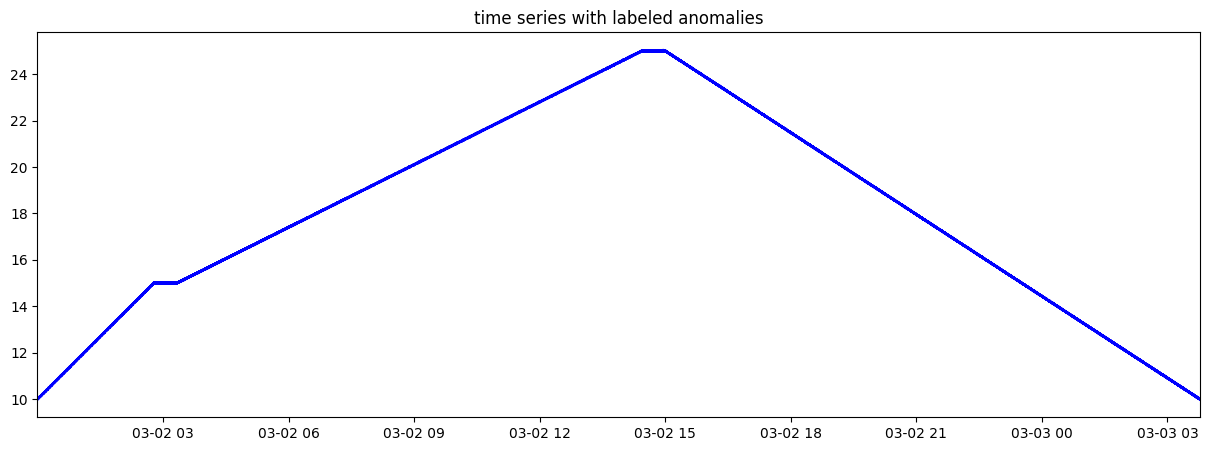

In [26]:
# plot time series with labeled anomalies

plot_time_series(path1x1.index.to_numpy(), path1x1.to_numpy(), 
                       title='time series with labeled anomalies')

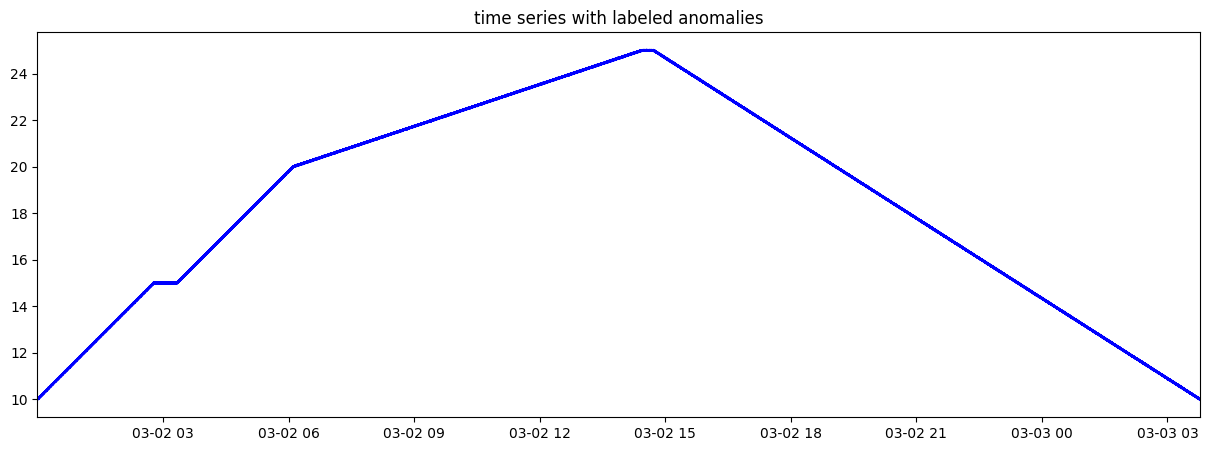

In [27]:
# plot time series with labeled anomalies

plot_time_series(path2x1.index.to_numpy(), path2x1.to_numpy(), 
                       title='time series with labeled anomalies')

In [38]:
# apply preprocessing pipeline
x= path1x1
x, t, x_win, t_win = pre_proc_apply_pipeline(x=x, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

In [39]:
x.shape

(100000,)

In [40]:
# instantiate and configure a TadGAN model

params = {
    'input_dim': WINDOW_SIZE,
    'latent_dim': LATENT_DIM,
    'learning_rate': LEARNING_RATE,
    'encoder': ENCODER_PARAMS,
    'generator': GENERATOR_PARAMS
}

model = TadGAN(**params)


In [41]:

# train the model

# t0 = time.time()
model.fit(x_win, epochs=EPOCHS)
# t1 = time.time()

Epoch 1/5 (93.8 secs)
  Critic X Loss: 0.224132 [-2.86934235  2.65876628  0.04347083]
  Critic Z Loss: -1.099062 [-1.81871304 -0.08181323  0.08014642]
  Encoder Generator Loss: -1.792940 [-2.64722225  0.42574322  0.04285388]
Epoch 2/5 (73.0 secs)
  Critic X Loss: 0.100722 [ 2.76731585 -2.91356667  0.02469732]
  Critic Z Loss: -1.465851 [-1.84417751 -0.30949329  0.06878197]
  Encoder Generator Loss: 3.719095 [2.9034648  0.58568251 0.02299473]
Epoch 3/5 (73.2 secs)
  Critic X Loss: 0.157783 [ 2.83371158 -2.86664243  0.01907143]
  Critic Z Loss: -2.133769 [-2.7804715   0.05185288  0.05948501]
  Encoder Generator Loss: 3.016746 [2.85099647 0.04201374 0.01237363]
Epoch 4/5 (73.3 secs)
  Critic X Loss: 0.275647 [-1.39646984  1.42392789  0.02481889]
  Critic Z Loss: -2.703181 [-3.37669803  0.13353769  0.05399798]
  Encoder Generator Loss: -1.329024 [-1.30615744 -0.08665868  0.00637923]
Epoch 5/5 (73.2 secs)
  Critic X Loss: 0.302951 [ 7.93882516 -7.88961159  0.02537373]
  Critic Z Loss: -2.22

In [42]:
# generate reconstructed time series segments

x_win_recon, critic_scores = model.predict(x_win)

In [43]:
x_win_recon

array([[-0.90058744, -0.91268456, -0.92926204, ..., -0.9538565 ,
        -0.9591267 , -0.92860705],
       [-0.90039915, -0.91249985, -0.9291063 , ..., -0.95371723,
        -0.9590539 , -0.9284559 ],
       [-0.9002846 , -0.91237575, -0.92899436, ..., -0.9536194 ,
        -0.95899826, -0.9283582 ],
       ...,
       [-0.90041494, -0.91251016, -0.9291156 , ..., -0.95374954,
        -0.95906067, -0.92849845],
       [-0.9005488 , -0.91265464, -0.92923456, ..., -0.9538345 ,
        -0.9591154 , -0.92861104],
       [-0.9006064 , -0.9127011 , -0.9292928 , ..., -0.95387524,
        -0.95913815, -0.9286537 ]], dtype=float32)

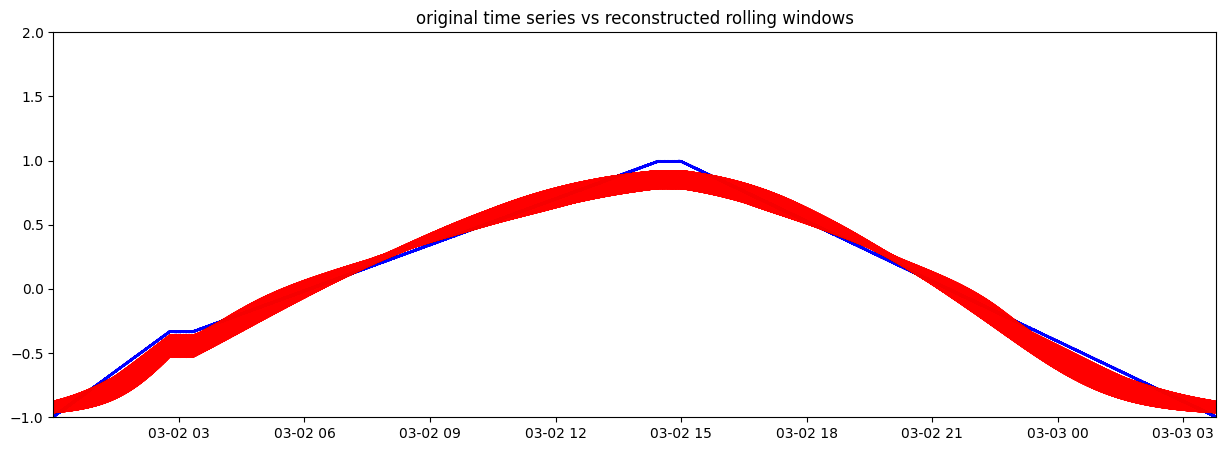

In [44]:
# plot the original time series and reconstructed segments

plot_time_series(t, x, x_win=x_win_recon, 
                       date_range=['2023-03-02 00:00:01', '2023-03-03 03:46:40'], value_range=[-1, 2],
                       title='original time series vs reconstructed rolling windows')


In [45]:
# apply preprocessing pipeline
x= path2x1
x, t, x_win, t_win = pre_proc_apply_pipeline(x=x, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

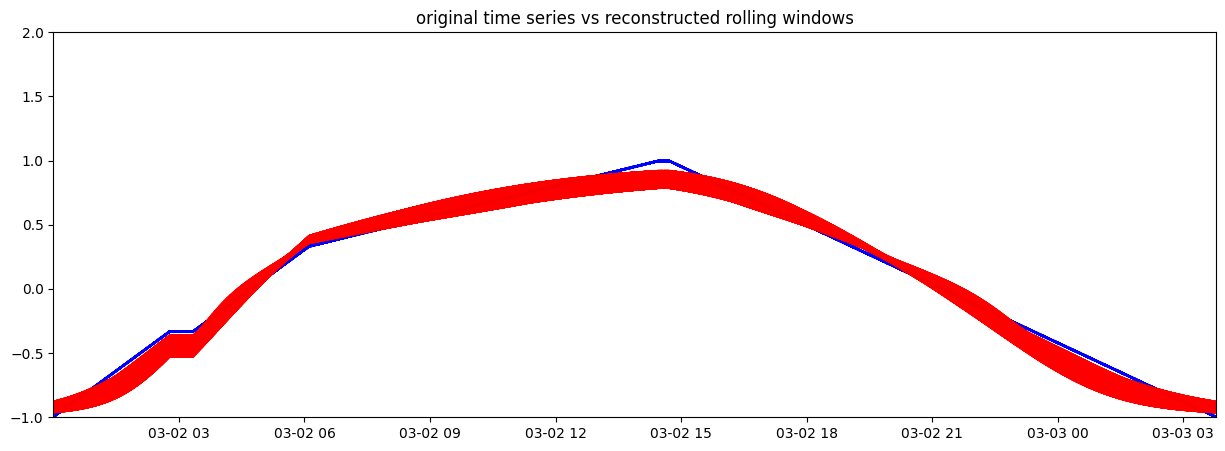

In [46]:
# generate reconstructed time series segments

x_win_recon, critic_scores = model.predict(x_win)

# plot the original time series and reconstructed segments

plot_time_series(t, x, x_win=x_win_recon, 
                       date_range=['2023-03-02 00:00:01', '2023-03-03 03:46:40'], value_range=[-1, 2],
                       title='original time series vs reconstructed rolling windows')
